<h1><center>Einführung in die Neuroinformatik - Übungsblatt 7</center></h1>
<h2><center>Dominik Authaler, Marco Deuscher und Carolin Schindler</center></h2>
<h2><center>Gruppe Q</center></h2>
<h2><center>Juni 2019</center></h2>

## Aufgabe 1: 

## Aufgabe 2:  
  
Erzeugung der Eingabedaten:

In [23]:
import numpy as np;
import itertools as it

def binaryCombinations(n):
    combinations = [];
    for i in range(2**n): #2^n possibilities to cover
        binNumber = format(i, 'b').zfill(n)
        vector = [];
        for j in range(n):
            if(binNumber[j] == '1'):
                vector.append(1);
            else:
                vector.append(0)
                
        combinations.append(vector)
                
    return np.array(combinations)

def generateInputCombinations(n): 
    x = binaryCombinations(n)
    y = binaryCombinations(n)
    return np.array(list(it.product(x,y)))

def generateTeachingSignal(n):
    teachingSignal = []
    inputSignal = generateInputCombinations(n);
    
    for i in range(len(inputSignal)):
        setpoint = np.dot(inputSignal[i][0],inputSignal[i][1]) % 2;
        teachingSignal.append(setpoint);
    
    inputSignal[inputSignal == 0] = -1;
    teachingSignal[teachingSignal == 0] = -1;
    
    return inputSignal, np.array(teachingSignal)  

In [156]:
import tensorflow as tf;
import tensorflow.keras.backend as K

def train_network(n_hidden,data,T):
    '''
    Trains a neural network and returns the lowest error.
    :param n_hidden: Number of hidden neurons to use per layer (as vector to indicate when multiple hidden
        layers should be used). For example, [2] uses one hidden layer with two neurons and [2, 2] uses two 
        hidden layers each with two neurons.
    :return: The lowest error (MSE) occurred over all training epochs.
    ''' 
    
    usedNeurons = 0;
    
    mySeed = 42;
    
    # Start fresh and at least try to get reproducible
    tf.reset_default_graph()
    K.clear_session()
    tf.set_random_seed(mySeed)
    np.random.seed(mySeed)
    
    session = tf.Session(config=None)
    tf.keras.backend.set_session(session)
    
    model = tf.keras.models.Sequential()
    
    batch, dim, length = data.shape;
    
    inputNeurons = dim*length;
    
    data = data.reshape(batch, inputNeurons);
    
    init = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=mySeed)
    acti = 'tanh'  
    
    if(isinstance(n_hidden, int)):
        numberOfLayers = 1;
        n_firstHidden = n_hidden;
    else:
        numberOfLayers = np.shape(n_hidden)[0]
        n_firstHidden = n_hidden[0];
        
    # Add first layer
    model.add(tf.keras.layers.Dense(units=n_firstHidden, input_dim = inputNeurons, activation=acti, kernel_initializer = init)) 
    usedNeurons += n_firstHidden;
    
    for layerNum in range(1, numberOfLayers): 
        model.add(tf.keras.layers.Dense(units = n_hidden[layerNum], activation=acti, kernel_initializer = init)) 
        usedNeurons += n_hidden[layerNum]
    
    # Add output layer
    model.add(tf.keras.layers.Dense(units = 1, activation=acti)) 
    usedNeurons += 1;
    
    #Plot model for debugging
    path = "./models/" + str(n_hidden) + ".png"
    tf.keras.utils.plot_model(model,path,show_shapes = True);
    
    sgd = tf.keras.optimizers.SGD(lr=0.02, decay=0.0001, momentum=0.9,nesterov=True)

    with session.as_default():
        with session.graph.as_default():
            model.compile(loss='mse',optimizer =sgd)
            history = model.fit(data,T,epochs=300)
            
            #Return min error and number of neurons
            return (min(history.history['loss']), usedNeurons)

Eigentliche Simulation

In [157]:
for n in range(3,7):
    min_loss_flat = []
    neurons_flat = []
    min_loss_deep = []
    neurons_deep = []
    
    data, T = generateTeachingSignal(n);

    for i in range(1,2**n+4):
        loss, neurons = train_network(i,data,T);
        min_loss_flat.append(loss);
        neurons_flat.append(neurons);

    for i in range(1,n+4):
        loss, neurons = train_network([i,i],data,T);
        min_loss_deep.append(loss)
        neurons_deep.append(neurons)

    print("Min Loss Flat: " + str(min_loss_flat))
    print("Used Neurons: " + str(neurons_flat))
    print("Min Loss Deep: " + str(min_loss_deep))

Epoch 1/300
64/64 [==============================] - 0s 5ms/sample - loss: 0.4477
Epoch 2/300
64/64 [==============================] - 0s 70us/sample - loss: 0.3862
Epoch 3/300
64/64 [==============================] - 0s 62us/sample - loss: 0.3245
Epoch 4/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2882
Epoch 5/300
64/64 [==============================] - 0s 133us/sample - loss: 0.2753
Epoch 6/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2776
Epoch 7/300
64/64 [==============================] - 0s 39us/sample - loss: 0.2837
Epoch 8/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2867
Epoch 9/300
64/64 [==============================] - 0s 31us/sample - loss: 0.2890
Epoch 10/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2882
Epoch 11/300
64/64 [==============================] - 0s 156us/sample - loss: 0.2851
Epoch 12/300
64/64 [==============================] - 0s 86us/sample - loss: 0.2831


64/64 [==============================] - 0s 62us/sample - loss: 0.2169
Epoch 98/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2165
Epoch 99/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2167
Epoch 100/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2160
Epoch 101/300
64/64 [==============================] - 0s 86us/sample - loss: 0.2159
Epoch 102/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2162
Epoch 103/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2154
Epoch 104/300
64/64 [==============================] - 0s 94us/sample - loss: 0.2153
Epoch 105/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2150
Epoch 106/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2149
Epoch 107/300
64/64 [==============================] - ETA: 0s - loss: 0.240 - 0s 94us/sample - loss: 0.2153
Epoch 108/300
64/64 [==============================] - 0s

64/64 [==============================] - 0s 55us/sample - loss: 0.2093
Epoch 194/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2094
Epoch 195/300
64/64 [==============================] - 0s 86us/sample - loss: 0.2092
Epoch 196/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2093
Epoch 197/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2093
Epoch 198/300
64/64 [==============================] - 0s 94us/sample - loss: 0.2101
Epoch 199/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2100
Epoch 200/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2098
Epoch 201/300
64/64 [==============================] - 0s 94us/sample - loss: 0.2092
Epoch 202/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2091
Epoch 203/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2092
Epoch 204/300
64/64 [==============================] - 0s 86us/sample - loss: 0

64/64 [==============================] - 0s 117us/sample - loss: 0.2084
Epoch 290/300
64/64 [==============================] - 0s 187us/sample - loss: 0.2084
Epoch 291/300
64/64 [==============================] - 0s 109us/sample - loss: 0.2086
Epoch 292/300
64/64 [==============================] - 0s 86us/sample - loss: 0.2087
Epoch 293/300
64/64 [==============================] - 0s 172us/sample - loss: 0.2086
Epoch 294/300
64/64 [==============================] - 0s 125us/sample - loss: 0.2083
Epoch 295/300
64/64 [==============================] - 0s 187us/sample - loss: 0.2083
Epoch 296/300
64/64 [==============================] - 0s 94us/sample - loss: 0.2084
Epoch 297/300
64/64 [==============================] - 0s 156us/sample - loss: 0.2088
Epoch 298/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2085
Epoch 299/300
64/64 [==============================] - 0s 195us/sample - loss: 0.2083
Epoch 300/300
64/64 [==============================] - 0s 140us/sample 

64/64 [==============================] - 0s 70us/sample - loss: 0.2128
Epoch 87/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2127
Epoch 88/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2126
Epoch 89/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2147
Epoch 90/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2125
Epoch 91/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2122
Epoch 92/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2124
Epoch 93/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2121
Epoch 94/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2121
Epoch 95/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2122
Epoch 96/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2116
Epoch 97/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2119
Epoch

64/64 [==============================] - 0s 133us/sample - loss: 0.2038
Epoch 183/300
64/64 [==============================] - ETA: 0s - loss: 0.169 - 0s 62us/sample - loss: 0.2035
Epoch 184/300
64/64 [==============================] - 0s 101us/sample - loss: 0.2040
Epoch 185/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2033
Epoch 186/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2031
Epoch 187/300
64/64 [==============================] - 0s 109us/sample - loss: 0.2031
Epoch 188/300
64/64 [==============================] - 0s 86us/sample - loss: 0.2029
Epoch 189/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2039
Epoch 190/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2029
Epoch 191/300
64/64 [==============================] - 0s 101us/sample - loss: 0.2025
Epoch 192/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2027
Epoch 193/300
64/64 [==============================

64/64 [==============================] - 0s 62us/sample - loss: 0.1905
Epoch 278/300
64/64 [==============================] - 0s 70us/sample - loss: 0.1906
Epoch 279/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1905
Epoch 280/300
64/64 [==============================] - 0s 109us/sample - loss: 0.1909
Epoch 281/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1901
Epoch 282/300
64/64 [==============================] - 0s 117us/sample - loss: 0.1897
Epoch 283/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1896
Epoch 284/300
64/64 [==============================] - 0s 117us/sample - loss: 0.1898
Epoch 285/300
64/64 [==============================] - 0s 86us/sample - loss: 0.1895
Epoch 286/300
64/64 [==============================] - 0s 109us/sample - loss: 0.1890
Epoch 287/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1894
Epoch 288/300
64/64 [==============================] - 0s 117us/sample - lo

64/64 [==============================] - 0s 62us/sample - loss: 0.2117
Epoch 75/300
64/64 [==============================] - 0s 101us/sample - loss: 0.2106
Epoch 76/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2105
Epoch 77/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2105
Epoch 78/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2105
Epoch 79/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2103
Epoch 80/300
64/64 [==============================] - 0s 125us/sample - loss: 0.2104
Epoch 81/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2109
Epoch 82/300
64/64 [==============================] - 0s 94us/sample - loss: 0.2100
Epoch 83/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2099
Epoch 84/300
64/64 [==============================] - 0s 86us/sample - loss: 0.2099
Epoch 85/300
64/64 [==============================] - 0s 94us/sample - loss: 0.2097
Epo

64/64 [==============================] - 0s 70us/sample - loss: 0.1965
Epoch 171/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1959
Epoch 172/300
64/64 [==============================] - 0s 70us/sample - loss: 0.1958
Epoch 173/300
64/64 [==============================] - 0s 70us/sample - loss: 0.1957
Epoch 174/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1949
Epoch 175/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1946
Epoch 176/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1945
Epoch 177/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1942
Epoch 178/300
64/64 [==============================] - 0s 86us/sample - loss: 0.1938
Epoch 179/300
64/64 [==============================] - 0s 94us/sample - loss: 0.1936
Epoch 180/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1931
Epoch 181/300
64/64 [==============================] - 0s 62us/sample - loss: 0

64/64 [==============================] - 0s 70us/sample - loss: 0.1642
Epoch 267/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1645
Epoch 268/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1629
Epoch 269/300
64/64 [==============================] - 0s 94us/sample - loss: 0.1628
Epoch 270/300
64/64 [==============================] - 0s 94us/sample - loss: 0.1628
Epoch 271/300
64/64 [==============================] - 0s 86us/sample - loss: 0.1622
Epoch 272/300
64/64 [==============================] - 0s 70us/sample - loss: 0.1621
Epoch 273/300
64/64 [==============================] - 0s 70us/sample - loss: 0.1615
Epoch 274/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1616
Epoch 275/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1611
Epoch 276/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1604
Epoch 277/300
64/64 [==============================] - 0s 62us/sample - loss: 0

64/64 [==============================] - 0s 55us/sample - loss: 0.2127
Epoch 64/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2127
Epoch 65/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2123
Epoch 66/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2120
Epoch 67/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2118
Epoch 68/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2116
Epoch 69/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2114
Epoch 70/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2114
Epoch 71/300
64/64 [==============================] - 0s 39us/sample - loss: 0.2113
Epoch 72/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2113
Epoch 73/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2113
Epoch 74/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2115
Epoch

Epoch 160/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1733
Epoch 161/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1724
Epoch 162/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1715
Epoch 163/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1704
Epoch 164/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1696
Epoch 165/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1685
Epoch 166/300
64/64 [==============================] - 0s 39us/sample - loss: 0.1670
Epoch 167/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1659
Epoch 168/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1648
Epoch 169/300
64/64 [==============================] - 0s 70us/sample - loss: 0.1640
Epoch 170/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1631
Epoch 171/300
64/64 [==============================] - 0s 47us/sa

64/64 [==============================] - 0s 62us/sample - loss: 0.0896
Epoch 257/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0889
Epoch 258/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0871
Epoch 259/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0864
Epoch 260/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0844
Epoch 261/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0827
Epoch 262/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0817
Epoch 263/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0801
Epoch 264/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0792
Epoch 265/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0782
Epoch 266/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0771
Epoch 267/300
64/64 [==============================] - 0s 55us/sample - loss: 0

64/64 [==============================] - 0s 47us/sample - loss: 0.2160
Epoch 54/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2156
Epoch 55/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2154
Epoch 56/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2158
Epoch 57/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2149
Epoch 58/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2144
Epoch 59/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2148
Epoch 60/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2140
Epoch 61/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2138
Epoch 62/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2134
Epoch 63/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2132
Epoch 64/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2130
Epoch

64/64 [==============================] - 0s 70us/sample - loss: 0.1109
Epoch 151/300
64/64 [==============================] - 0s 94us/sample - loss: 0.1087
Epoch 152/300
64/64 [==============================] - 0s 94us/sample - loss: 0.1070
Epoch 153/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1049
Epoch 154/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1037
Epoch 155/300
64/64 [==============================] - 0s 86us/sample - loss: 0.1022
Epoch 156/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1000
Epoch 157/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0986
Epoch 158/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0966
Epoch 159/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0952
Epoch 160/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0927
Epoch 161/300
64/64 [==============================] - 0s 55us/sample - loss: 0

64/64 [==============================] - 0s 47us/sample - loss: 0.0221
Epoch 247/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0217
Epoch 248/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0216
Epoch 249/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0213
Epoch 250/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0210
Epoch 251/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0208
Epoch 252/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0205
Epoch 253/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0203
Epoch 254/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0202
Epoch 255/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0198
Epoch 256/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0196
Epoch 257/300
64/64 [==============================] - 0s 55us/sample - loss: 0

64/64 [==============================] - 0s 70us/sample - loss: 0.1735
Epoch 44/300
64/64 [==============================] - 0s 101us/sample - loss: 0.1715
Epoch 45/300
64/64 [==============================] - 0s 86us/sample - loss: 0.1714
Epoch 46/300
64/64 [==============================] - 0s 86us/sample - loss: 0.1696
Epoch 47/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1669
Epoch 48/300
64/64 [==============================] - 0s 140us/sample - loss: 0.1661
Epoch 49/300
64/64 [==============================] - 0s 140us/sample - loss: 0.1646
Epoch 50/300
64/64 [==============================] - 0s 390us/sample - loss: 0.1625
Epoch 51/300
64/64 [==============================] - 0s 133us/sample - loss: 0.1611
Epoch 52/300
64/64 [==============================] - 0s 101us/sample - loss: 0.1600
Epoch 53/300
64/64 [==============================] - 0s 242us/sample - loss: 0.1586
Epoch 54/300
64/64 [==============================] - 0s 117us/sample - loss: 0.15

64/64 [==============================] - 0s 70us/sample - loss: 0.0599
Epoch 140/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0594
Epoch 141/300
64/64 [==============================] - 0s 172us/sample - loss: 0.0587
Epoch 142/300
64/64 [==============================] - 0s 109us/sample - loss: 0.0580
Epoch 143/300
64/64 [==============================] - 0s 125us/sample - loss: 0.0574
Epoch 144/300
64/64 [==============================] - 0s 140us/sample - loss: 0.0566
Epoch 145/300
64/64 [==============================] - 0s 117us/sample - loss: 0.0560
Epoch 146/300
64/64 [==============================] - 0s 86us/sample - loss: 0.0553
Epoch 147/300
64/64 [==============================] - 0s 164us/sample - loss: 0.0546
Epoch 148/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0541
Epoch 149/300
64/64 [==============================] - 0s 94us/sample - loss: 0.0533
Epoch 150/300
64/64 [==============================] - 0s 62us/sample - l

64/64 [==============================] - 0s 94us/sample - loss: 0.0088
Epoch 235/300
64/64 [==============================] - 0s 148us/sample - loss: 0.0087
Epoch 236/300
64/64 [==============================] - 0s 101us/sample - loss: 0.0086
Epoch 237/300
64/64 [==============================] - 0s 94us/sample - loss: 0.0086
Epoch 238/300
64/64 [==============================] - 0s 86us/sample - loss: 0.0084
Epoch 239/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0083
Epoch 240/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0082
Epoch 241/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0081
Epoch 242/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0080
Epoch 243/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0079
Epoch 244/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0078
Epoch 245/300
64/64 [==============================] - 0s 70us/sample - loss:

64/64 [==============================] - 0s 55us/sample - loss: 0.2161
Epoch 32/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2167
Epoch 33/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2153
Epoch 34/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2151
Epoch 35/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2145
Epoch 36/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2145
Epoch 37/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2135
Epoch 38/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2135
Epoch 39/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2126
Epoch 40/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2122
Epoch 41/300
64/64 [==============================] - 0s 39us/sample - loss: 0.2116
Epoch 42/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2116
Epoch

64/64 [==============================] - 0s 86us/sample - loss: 0.1611
Epoch 128/300
64/64 [==============================] - ETA: 0s - loss: 0.134 - 0s 62us/sample - loss: 0.1603
Epoch 129/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1597
Epoch 130/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1596
Epoch 131/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1590
Epoch 132/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1583
Epoch 133/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1570
Epoch 134/300
64/64 [==============================] - 0s 86us/sample - loss: 0.1570
Epoch 135/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1566
Epoch 136/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1560
Epoch 137/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1559
Epoch 138/300
64/64 [==============================] - 

64/64 [==============================] - 0s 47us/sample - loss: 0.1119
Epoch 224/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1119
Epoch 225/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1115
Epoch 226/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1112
Epoch 227/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1114
Epoch 228/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1110
Epoch 229/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1099
Epoch 230/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1096
Epoch 231/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1093
Epoch 232/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1099
Epoch 233/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1088
Epoch 234/300
64/64 [==============================] - 0s 55us/sample - loss: 0

64/64 [==============================] - 0s 62us/sample - loss: 0.2296
Epoch 20/300
64/64 [==============================] - 0s 39us/sample - loss: 0.2278
Epoch 21/300
64/64 [==============================] - 0s 54us/sample - loss: 0.2271
Epoch 22/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2278
Epoch 23/300
64/64 [==============================] - 0s 39us/sample - loss: 0.2266
Epoch 24/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2275
Epoch 25/300
64/64 [==============================] - 0s 101us/sample - loss: 0.2260
Epoch 26/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2253
Epoch 27/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2256
Epoch 28/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2244
Epoch 29/300
64/64 [==============================] - 0s 39us/sample - loss: 0.2235
Epoch 30/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2231
Epoc

64/64 [==============================] - 0s 55us/sample - loss: 0.1774
Epoch 117/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1760
Epoch 118/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1756
Epoch 119/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1742
Epoch 120/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1729
Epoch 121/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1720
Epoch 122/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1708
Epoch 123/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1695
Epoch 124/300
64/64 [==============================] - 0s 39us/sample - loss: 0.1682
Epoch 125/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1672
Epoch 126/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1654
Epoch 127/300
64/64 [==============================] - 0s 70us/sample - loss: 0

64/64 [==============================] - 0s 70us/sample - loss: 0.0401
Epoch 213/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0393
Epoch 214/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0380
Epoch 215/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0368
Epoch 216/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0359
Epoch 217/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0348
Epoch 218/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0339
Epoch 219/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0328
Epoch 220/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0319
Epoch 221/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0310
Epoch 222/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0302
Epoch 223/300
64/64 [==============================] - 0s 55us/sample - loss: 0

64/64 [==============================] - 0s 47us/sample - loss: 0.2549
Epoch 9/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2469
Epoch 10/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2425
Epoch 11/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2376
Epoch 12/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2371
Epoch 13/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2346
Epoch 14/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2326
Epoch 15/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2310
Epoch 16/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2273
Epoch 17/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2263
Epoch 18/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2238
Epoch 19/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2227
Epoch 

64/64 [==============================] - 0s 55us/sample - loss: 0.1486
Epoch 106/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1473
Epoch 107/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1468
Epoch 108/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1448
Epoch 109/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1433
Epoch 110/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1426
Epoch 111/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1406
Epoch 112/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1394
Epoch 113/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1378
Epoch 114/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1364
Epoch 115/300
64/64 [==============================] - 0s 86us/sample - loss: 0.1351
Epoch 116/300
64/64 [==============================] - 0s 55us/sample - loss: 0

64/64 [==============================] - 0s 54us/sample - loss: 0.0216
Epoch 202/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0213
Epoch 203/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0209
Epoch 204/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0205
Epoch 205/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0200
Epoch 206/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0196
Epoch 207/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0192
Epoch 208/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0189
Epoch 209/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0185
Epoch 210/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0182
Epoch 211/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0179
Epoch 212/300
64/64 [==============================] - 0s 47us/sample - loss: 0

64/64 [==============================] - 0s 70us/sample - loss: 0.0063
Epoch 298/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0062
Epoch 299/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0062
Epoch 300/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0061
Epoch 1/300
64/64 [==============================] - 0s 3ms/sample - loss: 0.6909
Epoch 2/300
64/64 [==============================] - 0s 70us/sample - loss: 0.5232
Epoch 3/300
64/64 [==============================] - 0s 55us/sample - loss: 0.3448
Epoch 4/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2628
Epoch 5/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2364
Epoch 6/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2405
Epoch 7/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2421
Epoch 8/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2446
Epoch 9/300

64/64 [==============================] - 0s 62us/sample - loss: 0.1091
Epoch 95/300
64/64 [==============================] - ETA: 0s - loss: 0.107 - 0s 55us/sample - loss: 0.1076
Epoch 96/300
64/64 [==============================] - 0s 70us/sample - loss: 0.1066
Epoch 97/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1043
Epoch 98/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1032
Epoch 99/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1019
Epoch 100/300
64/64 [==============================] - 0s 70us/sample - loss: 0.1004
Epoch 101/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0987
Epoch 102/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0974
Epoch 103/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0954
Epoch 104/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0935
Epoch 105/300
64/64 [==============================] - 0s 55

64/64 [==============================] - 0s 62us/sample - loss: 0.0111
Epoch 191/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0110
Epoch 192/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0108
Epoch 193/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0107
Epoch 194/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0105
Epoch 195/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0104
Epoch 196/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0103
Epoch 197/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0101
Epoch 198/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0101
Epoch 199/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0100
Epoch 200/300
64/64 [==============================] - 0s 86us/sample - loss: 0.0098
Epoch 201/300
64/64 [==============================] - 0s 62us/sample - loss: 0

64/64 [==============================] - 0s 55us/sample - loss: 0.0045
Epoch 287/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0045
Epoch 288/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0045
Epoch 289/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0044
Epoch 290/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0044
Epoch 291/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0044
Epoch 292/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0044
Epoch 293/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0043
Epoch 294/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0043
Epoch 295/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0043
Epoch 296/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0043
Epoch 297/300
64/64 [==============================] - 0s 62us/sample - loss: 0

64/64 [==============================] - 0s 62us/sample - loss: 0.1380
Epoch 84/300
64/64 [==============================] - 0s 117us/sample - loss: 0.1346
Epoch 85/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1330
Epoch 86/300
64/64 [==============================] - 0s 86us/sample - loss: 0.1307
Epoch 87/300
64/64 [==============================] - 0s 125us/sample - loss: 0.1285
Epoch 88/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1268
Epoch 89/300
64/64 [==============================] - 0s 109us/sample - loss: 0.1267
Epoch 90/300
64/64 [==============================] - 0s 70us/sample - loss: 0.1220
Epoch 91/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1199
Epoch 92/300
64/64 [==============================] - 0s 125us/sample - loss: 0.1181
Epoch 93/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1165
Epoch 94/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1134
E

64/64 [==============================] - 0s 55us/sample - loss: 0.0122
Epoch 180/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0120
Epoch 181/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0119
Epoch 182/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0116
Epoch 183/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0114
Epoch 184/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0113
Epoch 185/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0111
Epoch 186/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0109
Epoch 187/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0108
Epoch 188/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0106
Epoch 189/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0104
Epoch 190/300
64/64 [==============================] - 0s 55us/sample - loss: 0

64/64 [==============================] - 0s 70us/sample - loss: 0.0048
Epoch 276/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0048
Epoch 277/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0047
Epoch 278/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0047
Epoch 279/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0047
Epoch 280/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0047
Epoch 281/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0046
Epoch 282/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0046
Epoch 283/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0046
Epoch 284/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0045
Epoch 285/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0045
Epoch 286/300
64/64 [==============================] - 0s 47us/sample - loss: 0

64/64 [==============================] - 0s 47us/sample - loss: 0.2177
Epoch 73/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2181
Epoch 74/300
64/64 [==============================] - 0s 54us/sample - loss: 0.2182
Epoch 75/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2166
Epoch 76/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2163
Epoch 77/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2162
Epoch 78/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2164
Epoch 79/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2155
Epoch 80/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2160
Epoch 81/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2165
Epoch 82/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2151
Epoch 83/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2148
Epoch

64/64 [==============================] - 0s 55us/sample - loss: 0.2090
Epoch 169/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2095
Epoch 170/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2101
Epoch 171/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2093
Epoch 172/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2092
Epoch 173/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2097
Epoch 174/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2091
Epoch 175/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2090
Epoch 176/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2092
Epoch 177/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2091
Epoch 178/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2090
Epoch 179/300
64/64 [==============================] - 0s 62us/sample - loss: 0

64/64 [==============================] - 0s 55us/sample - loss: 0.2086
Epoch 265/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2088
Epoch 266/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2086
Epoch 267/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2088
Epoch 268/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2085
Epoch 269/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2090
Epoch 270/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2091
Epoch 271/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2085
Epoch 272/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2088
Epoch 273/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2086
Epoch 274/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2087
Epoch 275/300
64/64 [==============================] - 0s 70us/sample - loss: 0

64/64 [==============================] - 0s 70us/sample - loss: 0.2222
Epoch 62/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2220
Epoch 63/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2227
Epoch 64/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2223
Epoch 65/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2206
Epoch 66/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2206
Epoch 67/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2198
Epoch 68/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2196
Epoch 69/300
64/64 [==============================] - 0s 39us/sample - loss: 0.2191
Epoch 70/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2194
Epoch 71/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2188
Epoch 72/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2189
Epoch

Epoch 158/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2089
Epoch 159/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2091
Epoch 160/300
64/64 [==============================] - 0s 39us/sample - loss: 0.2084
Epoch 161/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2086
Epoch 162/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2084
Epoch 163/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2084
Epoch 164/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2089
Epoch 165/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2089
Epoch 166/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2084
Epoch 167/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2082
Epoch 168/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2082
Epoch 169/300
64/64 [==============================] - 0s 55us/sa

64/64 [==============================] - 0s 94us/sample - loss: 0.2007
Epoch 255/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2001
Epoch 256/300
64/64 [==============================] - 0s 133us/sample - loss: 0.1997
Epoch 257/300
64/64 [==============================] - 0s 101us/sample - loss: 0.2008
Epoch 258/300
64/64 [==============================] - 0s 148us/sample - loss: 0.1997
Epoch 259/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2008
Epoch 260/300
64/64 [==============================] - 0s 133us/sample - loss: 0.2007
Epoch 261/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1990
Epoch 262/300
64/64 [==============================] - 0s 86us/sample - loss: 0.1992
Epoch 263/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1992
Epoch 264/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1989
Epoch 265/300
64/64 [==============================] - 0s 70us/sample - los

64/64 [==============================] - 0s 62us/sample - loss: 0.2160
Epoch 52/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2162
Epoch 53/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2162
Epoch 54/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2156
Epoch 55/300
64/64 [==============================] - 0s 289us/sample - loss: 0.2150
Epoch 56/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2178
Epoch 57/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2151
Epoch 58/300
64/64 [==============================] - 0s 109us/sample - loss: 0.2142
Epoch 59/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2149
Epoch 60/300
64/64 [==============================] - 0s 109us/sample - loss: 0.2138
Epoch 61/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2135
Epoch 62/300
64/64 [==============================] - ETA: 0s - loss: 0.180 - 0s 62us/

64/64 [==============================] - 0s 62us/sample - loss: 0.1293
Epoch 148/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1284
Epoch 149/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1255
Epoch 150/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1261
Epoch 151/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1229
Epoch 152/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1204
Epoch 153/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1183
Epoch 154/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1166
Epoch 155/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1150
Epoch 156/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1131
Epoch 157/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1124
Epoch 158/300
64/64 [==============================] - 0s 47us/sample - loss: 0

64/64 [==============================] - 0s 117us/sample - loss: 0.0664
Epoch 244/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0656
Epoch 245/300
64/64 [==============================] - 0s 86us/sample - loss: 0.0656
Epoch 246/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0661
Epoch 247/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0662
Epoch 248/300
64/64 [==============================] - 0s 109us/sample - loss: 0.0651
Epoch 249/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0650
Epoch 250/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0653
Epoch 251/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0657
Epoch 252/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0656
Epoch 253/300
64/64 [==============================] - 0s 86us/sample - loss: 0.0653
Epoch 254/300
64/64 [==============================] - 0s 55us/sample - loss:

64/64 [==============================] - 0s 86us/sample - loss: 0.2149
Epoch 41/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2146
Epoch 42/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2146
Epoch 43/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2137
Epoch 44/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2126
Epoch 45/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2149
Epoch 46/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2158
Epoch 47/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2117
Epoch 48/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2119
Epoch 49/300
64/64 [==============================] - 0s 55us/sample - loss: 0.2110
Epoch 50/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2104
Epoch 51/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2100
Epoch

64/64 [==============================] - 0s 47us/sample - loss: 0.1766
Epoch 138/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1753
Epoch 139/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1746
Epoch 140/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1743
Epoch 141/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1746
Epoch 142/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1742
Epoch 143/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1735
Epoch 144/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1754
Epoch 145/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1735
Epoch 146/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1735
Epoch 147/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1723
Epoch 148/300
64/64 [==============================] - 0s 47us/sample - loss: 0

64/64 [==============================] - 0s 55us/sample - loss: 0.1093
Epoch 234/300
64/64 [==============================] - 0s 39us/sample - loss: 0.1099
Epoch 235/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1082
Epoch 236/300
64/64 [==============================] - 0s 39us/sample - loss: 0.1087
Epoch 237/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1090
Epoch 238/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1076
Epoch 239/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1062
Epoch 240/300
64/64 [==============================] - 0s 62us/sample - loss: 0.1049
Epoch 241/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1049
Epoch 242/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1050
Epoch 243/300
64/64 [==============================] - 0s 70us/sample - loss: 0.1042
Epoch 244/300
64/64 [==============================] - 0s 62us/sample - loss: 0

Epoch 30/300
64/64 [==============================] - 0s 94us/sample - loss: 0.2074
Epoch 31/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2056
Epoch 32/300
64/64 [==============================] - 0s 94us/sample - loss: 0.2062
Epoch 33/300
64/64 [==============================] - 0s 94us/sample - loss: 0.2045
Epoch 34/300
64/64 [==============================] - 0s 117us/sample - loss: 0.2037
Epoch 35/300
64/64 [==============================] - 0s 94us/sample - loss: 0.2019
Epoch 36/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2019
Epoch 37/300
64/64 [==============================] - 0s 94us/sample - loss: 0.2002
Epoch 38/300
64/64 [==============================] - 0s 94us/sample - loss: 0.1989
Epoch 39/300
64/64 [==============================] - 0s 94us/sample - loss: 0.1987
Epoch 40/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1961
Epoch 41/300
64/64 [==============================] - 0s 78us/sample - loss

64/64 [==============================] - 0s 78us/sample - loss: 0.0520
Epoch 128/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0507
Epoch 129/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0495
Epoch 130/300
64/64 [==============================] - 0s 86us/sample - loss: 0.0491
Epoch 131/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0479
Epoch 132/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0481
Epoch 133/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0467
Epoch 134/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0462
Epoch 135/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0462
Epoch 136/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0449
Epoch 137/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0453
Epoch 138/300
64/64 [==============================] - 0s 62us/sample - loss: 0

64/64 [==============================] - 0s 70us/sample - loss: 0.0078
Epoch 224/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0075
Epoch 225/300
64/64 [==============================] - 0s 86us/sample - loss: 0.0076
Epoch 226/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0073
Epoch 227/300
64/64 [==============================] - 0s 86us/sample - loss: 0.0071
Epoch 228/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0070
Epoch 229/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0070
Epoch 230/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0071
Epoch 231/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0067
Epoch 232/300
64/64 [==============================] - 0s 86us/sample - loss: 0.0067
Epoch 233/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0063
Epoch 234/300
64/64 [==============================] - 0s 78us/sample - loss: 0

64/64 [==============================] - 0s 55us/sample - loss: 0.2063
Epoch 20/300
64/64 [==============================] - 0s 101us/sample - loss: 0.2044
Epoch 21/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2027
Epoch 22/300
64/64 [==============================] - 0s 70us/sample - loss: 0.2019
Epoch 23/300
64/64 [==============================] - 0s 86us/sample - loss: 0.1998
Epoch 24/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2014
Epoch 25/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1965
Epoch 26/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1953
Epoch 27/300
64/64 [==============================] - 0s 70us/sample - loss: 0.1949
Epoch 28/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1925
Epoch 29/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1892
Epoch 30/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1878
Epoc

64/64 [==============================] - 0s 70us/sample - loss: 0.0530
Epoch 117/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0529
Epoch 118/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0523
Epoch 119/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0524
Epoch 120/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0523
Epoch 121/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0516
Epoch 122/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0516
Epoch 123/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0510
Epoch 124/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0501
Epoch 125/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0500
Epoch 126/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0501
Epoch 127/300
64/64 [==============================] - 0s 78us/sample - loss: 0

64/64 [==============================] - 0s 226us/sample - loss: 0.0117
Epoch 213/300
64/64 [==============================] - 0s 140us/sample - loss: 0.0113
Epoch 214/300
64/64 [==============================] - 0s 156us/sample - loss: 0.0111
Epoch 215/300
64/64 [==============================] - 0s 203us/sample - loss: 0.0110
Epoch 216/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0107
Epoch 217/300
64/64 [==============================] - 0s 195us/sample - loss: 0.0106
Epoch 218/300
64/64 [==============================] - 0s 172us/sample - loss: 0.0104
Epoch 219/300
64/64 [==============================] - 0s 109us/sample - loss: 0.0101
Epoch 220/300
64/64 [==============================] - 0s 125us/sample - loss: 0.0099
Epoch 221/300
64/64 [==============================] - 0s 140us/sample - loss: 0.0098
Epoch 222/300
64/64 [==============================] - 0s 133us/sample - loss: 0.0096
Epoch 223/300
64/64 [==============================] - 0s 86us/sample

Visualisierung der Daten:

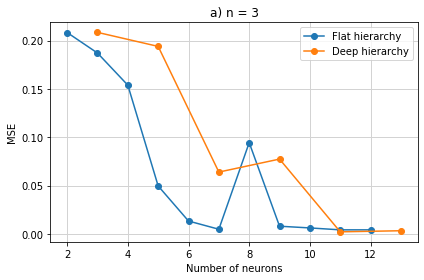

In [158]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.title("a) n = 3")
plt.xlabel('Number of neurons')
plt.ylabel('MSE')
plt.plot(neurons_flat, min_loss_flat, label='Flat hierarchy', marker='o')
plt.plot(neurons_deep, min_loss_deep, label='Deep hierarchy', marker='o')
plt.tight_layout()
plt.legend()
plt.grid(color='lightgrey', linestyle='-', linewidth=1)